In [1]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
hist_df = pd.read_csv('/Users/jincui/Downloads/ELO/historical_transactions.csv')


KeyError: 'purchase_date_month'

In [4]:
hist_df['purchase_date'].min()

'2017-01-01 00:00:08'

In [5]:
hist_df['purchase_date'].max()

'2018-02-28 23:59:51'

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [4]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
    

In [5]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')


In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
def train_test(num_rows=None):

    # load csv
    train_df = pd.read_csv('/Users/jincui/Downloads/ELO/train.csv', index_col=['card_id'], nrows=num_rows)
    test_df = pd.read_csv('/Users/jincui/Downloads/ELO/test.csv', index_col=['card_id'], nrows=num_rows)

    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))

    # outlier
    train_df['outliers'] = 0
    train_df.loc[train_df['target'] < -30, 'outliers'] = 1

    # set target as nan
    test_df['target'] = np.nan

    # merge
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    # to datetime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    # one hot encoding
    df, cols = one_hot_encoder(df, nan_as_category=False)

    for f in ['feature_1','feature_2','feature_3']:
        order_label = df.groupby([f])['outliers'].mean()
        df[f] = df[f].map(order_label)

    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum']/3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

    return df

In [65]:
df['feature_1'].value_counts()

3    118292
2     89912
5     65676
4     32217
1     19443
Name: feature_1, dtype: int64

In [8]:
def historical_transactions(num_rows=None):
    # load csv
    hist_df = pd.read_csv('/Users/jincui/Downloads/ELO/historical_transactions.csv', nrows=num_rows)

    # fillna
    hist_df['category_2'].fillna(1.0,inplace=True)
    hist_df['category_3'].fillna('A',inplace=True)
    hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    hist_df['installments'].replace(-1, np.nan,inplace=True)
    hist_df['installments'].replace(999, np.nan,inplace=True)

    # trim
    hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_3'] = hist_df['category_3'].map({'A':0, 'B':1, 'C':2})

    # datetime features
    hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
    hist_df['month'] = hist_df['purchase_date'].dt.month
    hist_df['day'] = hist_df['purchase_date'].dt.day
    hist_df['hour'] = hist_df['purchase_date'].dt.hour
    hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear
    hist_df['weekday'] = hist_df['purchase_date'].dt.weekday
    hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >=5).astype(int)

    # additional features
    hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']

    #Christmas : December 25 2017
    hist_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 14 2017
    hist_df['Mothers_Day_2017']=(pd.to_datetime('2017-06-04')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #fathers day: August 13 2017
    hist_df['fathers_day_2017']=(pd.to_datetime('2017-08-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    hist_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Valentine's Day : 12th June, 2017
    hist_df['Valentine_Day_2017']=(pd.to_datetime('2017-06-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    hist_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #2018
    #Mothers Day: May 13 2018
    hist_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    hist_df['month_diff'] = ((datetime.datetime.today() - hist_df['purchase_date']).dt.days)//30
    hist_df['month_diff'] += hist_df['month_lag']

    # additional features
    hist_df['duration'] = hist_df['purchase_amount']*hist_df['month_diff']
    hist_df['amount_month_ratio'] = hist_df['purchase_amount']/hist_df['month_diff']

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['max','min','mean','var','skew']
    aggs['authorized_flag'] = ['mean']
    aggs['weekend'] = ['mean'] # overwrite
    aggs['weekday'] = ['mean'] # overwrite
    aggs['day'] = ['nunique', 'mean', 'min'] # overwrite
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['sum','mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Mothers_Day_2017'] = ['mean']
    aggs['fathers_day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Valentine_Day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        hist_df[col+'_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
        hist_df[col+'_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
        hist_df[col+'_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
        hist_df[col+'_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
    hist_df.columns = ['hist_'+ c for c in hist_df.columns]

    hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max']-hist_df['hist_purchase_date_min']).dt.days
    hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff']/hist_df['hist_card_id_size']
    hist_df['hist_purchase_date_uptonow'] = (datetime.datetime.today()-hist_df['hist_purchase_date_max']).dt.days
    hist_df['hist_purchase_date_uptomin'] = (datetime.datetime.today()-hist_df['hist_purchase_date_min']).dt.days

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    return hist_df

In [3]:
new_merchant_df = pd.read_csv('/Users/jincui/Downloads/ELO/new_merchant_transactions.csv')
new_merchant_df['authorized_flag'].unique()


array(['Y'], dtype=object)

In [9]:
def new_merchant_transactions(num_rows=None):
    # load csv
    new_merchant_df = pd.read_csv('/Users/jincui/Downloads/ELO/new_merchant_transactions.csv', nrows=num_rows)

    # fillna
    new_merchant_df['category_2'].fillna(1.0,inplace=True)
    new_merchant_df['category_3'].fillna('A',inplace=True)
    new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    new_merchant_df['installments'].replace(-1, np.nan,inplace=True)
    new_merchant_df['installments'].replace(999, np.nan,inplace=True)

    # trim
    new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

    # datetime features
    new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
    new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
    new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
    new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
    new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].dt.weekofyear
    new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
    new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >=5).astype(int)

    # additional features
    new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']

    #Christmas : December 25 2017
    new_merchant_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    new_merchant_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    new_merchant_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #Mothers Day: May 13 2018
    new_merchant_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    new_merchant_df['month_diff'] = ((datetime.datetime.today() - new_merchant_df['purchase_date']).dt.days)//30
    new_merchant_df['month_diff'] += new_merchant_df['month_lag']

    # additional features
    new_merchant_df['duration'] = new_merchant_df['purchase_amount']*new_merchant_df['month_diff']
    new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount']/new_merchant_df['month_diff']

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['mean','var','skew']
    aggs['weekend'] = ['mean']
    aggs['month'] = ['mean', 'min', 'max']
    aggs['weekday'] = ['mean', 'min', 'max']
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        new_merchant_df[col+'_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
        new_merchant_df[col+'_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
        new_merchant_df[col+'_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
        new_merchant_df[col+'_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
    new_merchant_df.columns = ['new_'+ c for c in new_merchant_df.columns]

    new_merchant_df['new_purchase_date_diff'] = (new_merchant_df['new_purchase_date_max']-new_merchant_df['new_purchase_date_min']).dt.days
    new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff']/new_merchant_df['new_card_id_size']
    new_merchant_df['new_purchase_date_uptonow'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_max']).dt.days
    new_merchant_df['new_purchase_date_uptomin'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_min']).dt.days

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    return new_merchant_df

In [10]:
def additional_features(df):
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features=['hist_purchase_date_max','hist_purchase_date_min',
                   'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count']+df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count']/df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum']/df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean']+df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min']+df['hist_duration_min']
    df['duration_max'] = df['new_duration_max']+df['hist_duration_max']
    df['amount_month_ratio_mean']=df['new_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min']=df['new_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max']=df['new_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

    return df

In [58]:
# originally stratified is False
def kfold_lightgbm(train_df, test_df, num_folds, stratified = True, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    val_rmse = rmse(oof_preds, train_df['target'])
    print('validation rmse is: {}'.format(val_rmse))
        
        
    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        test_df.loc[:,'target'] = sub_preds
        test_df = test_df.reset_index()
        test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)

In [59]:
def main(debug=False):
    num_rows = 10000 if debug else None
    with timer("train & test"):
        df = train_test(num_rows)
    with timer("historical transactions"):
        df = pd.merge(df, historical_transactions(num_rows), on='card_id', how='outer')
    with timer("new merchants"):
        df = pd.merge(df, new_merchant_transactions(num_rows), on='card_id', how='outer')
    with timer("additional features"):
        df = additional_features(df)
    with timer("split train & test"):
        train_df = df[df['target'].notnull()]
        test_df = df[df['target'].isnull()]
        del df
        gc.collect()
        
        
        train_df.to_hdf('Elo_fe.h5', 'train_fe_3691')
        test_df.to_hdf('Elo_fe.h5', 'test_fe_3691')
        
        
    with timer("Run LightGBM with kfold"):
        kfold_lightgbm(train_df, test_df, num_folds=11, stratified=False, debug=debug)

Train samples: 201917, test samples: 123623
train & test - done in 3s
Memory usage after optimization is: 1832.41 MB
Decreased by 73.4%
Memory usage after optimization is: 56.19 MB
Decreased by 57.6%
historical transactions - done in 1045s
Memory usage after optimization is: 117.94 MB
Decreased by 71.9%
Memory usage after optimization is: 44.53 MB
Decreased by 57.6%
new merchants - done in 519s
additional features - done in 0s
split train & test - done in 2s
Starting LightGBM. Train shape: (201917, 202), test shape: (123623, 202)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65836	test's rmse: 3.73649
[200]	train's rmse: 3.58073	test's rmse: 3.70016
[300]	train's rmse: 3.5327	test's rmse: 3.68752
[400]	train's rmse: 3.49749	test's rmse: 3.68214
[500]	train's rmse: 3.47145	test's rmse: 3.67989
[600]	train's rmse: 3.45035	test's rmse: 3.67809
[700]	train's rmse: 3.42972	test's rmse: 3.67705
[800]	train's rmse: 3.41015	test's rmse: 3.67641
[900]	trai

[300]	train's rmse: 3.53434	test's rmse: 3.67425
[400]	train's rmse: 3.50174	test's rmse: 3.66913
[500]	train's rmse: 3.47519	test's rmse: 3.66632
[600]	train's rmse: 3.45324	test's rmse: 3.66491
[700]	train's rmse: 3.43317	test's rmse: 3.66402
[800]	train's rmse: 3.41404	test's rmse: 3.66328
[900]	train's rmse: 3.39491	test's rmse: 3.66277
[1000]	train's rmse: 3.37959	test's rmse: 3.66306
Early stopping, best iteration is:
[896]	train's rmse: 3.39576	test's rmse: 3.66275
Fold 11 RMSE : 3.662739
validation rmse is: 3.6489641438085743
Run LightGBM with kfold - done in 1239s
Full model run - done in 2809s


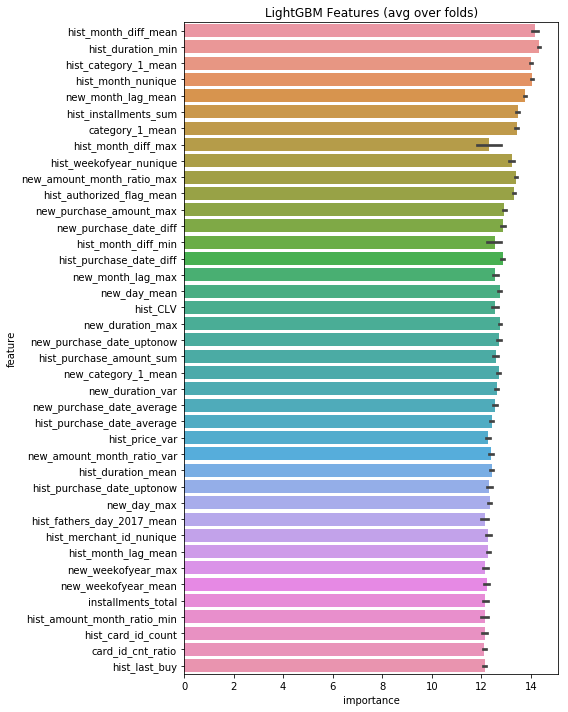

In [60]:
if __name__ == "__main__":
    submission_file_name = "submission.csv"
    with timer("Full model run"):
        main(debug=False)

In [38]:
import optuna
def objective(trial):
    x = trial.suggest_uniform('x', -10, 10)
    return (x-2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2019-01-27 01:40:33,045] Finished a trial resulted in value: 18.94333055601073. Current best value is 18.94333055601073 with parameters: {'x': -2.3523936582081735}.
[I 2019-01-27 01:40:33,049] Finished a trial resulted in value: 28.780156643829773. Current best value is 18.94333055601073 with parameters: {'x': -2.3523936582081735}.
[I 2019-01-27 01:40:33,053] Finished a trial resulted in value: 21.474685857290886. Current best value is 18.94333055601073 with parameters: {'x': -2.3523936582081735}.
[I 2019-01-27 01:40:33,057] Finished a trial resulted in value: 0.41821105301723394. Current best value is 0.41821105301723394 with parameters: {'x': 2.6466923944328045}.
[I 2019-01-27 01:40:33,059] Finished a trial resulted in value: 1.1427450862120132. Current best value is 0.41821105301723394 with parameters: {'x': 2.6466923944328045}.
[I 2019-01-27 01:40:33,063] Finished a trial resulted in value: 60.854877828931244. Current best value is 0.41821105301723394 with parameters: {'x': 2.64

[I 2019-01-27 01:40:34,101] Finished a trial resulted in value: 55.669216649079516. Current best value is 0.0012668334063464933 with parameters: {'x': 1.9644073967467046}.
[I 2019-01-27 01:40:34,115] Finished a trial resulted in value: 0.38942340030598027. Current best value is 0.0012668334063464933 with parameters: {'x': 1.9644073967467046}.
[I 2019-01-27 01:40:34,129] Finished a trial resulted in value: 54.89347447645473. Current best value is 0.0012668334063464933 with parameters: {'x': 1.9644073967467046}.
[I 2019-01-27 01:40:34,145] Finished a trial resulted in value: 16.404153242866748. Current best value is 0.0012668334063464933 with parameters: {'x': 1.9644073967467046}.
[I 2019-01-27 01:40:34,160] Finished a trial resulted in value: 2.2332043660825653. Current best value is 0.0012668334063464933 with parameters: {'x': 1.9644073967467046}.


In [41]:
print(study.best_params)
print(study.best_value)
print(study.best_trial)

{'x': 1.9644073967467046}
0.0012668334063464933
FrozenTrial(trial_id=65, state=<TrialState.COMPLETE: 1>, value=0.0012668334063464933, datetime_start=datetime.datetime(2019, 1, 27, 1, 40, 33, 669106), datetime_complete=datetime.datetime(2019, 1, 27, 1, 40, 33, 673315), params={'x': 1.9644073967467046}, user_attrs={}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'x': 1.9644073967467046})


In [49]:
from sklearn.datasets import load_iris

def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if classifier_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        classifier_obj = SVC(C=svc_c)
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth)

    iris = load_iris()
    x, y = iris.data , iris.target
    score = sklearn.model_selection.cross_val_score(classifier_obj , x, y)
    accuracy = score.mean()
    
    return 1.0 - accuracy  # A objective value linked with the Trial object.

study = optuna.create_study()  # Create a new study.
study.optimize(objective , n_trials=100)  # Invoke optimization of the objective function.

[I 2019-01-27 02:01:58,971] Finished a trial resulted in value: 0.053104575163398615. Current best value is 0.053104575163398615 with parameters: {'classifier': 'RandomForest', 'rf_max_depth': 14}.
[I 2019-01-27 02:01:58,985] Finished a trial resulted in value: 0.060049019607843146. Current best value is 0.053104575163398615 with parameters: {'classifier': 'RandomForest', 'rf_max_depth': 14}.
[I 2019-01-27 02:01:59,000] Finished a trial resulted in value: 0.060049019607843146. Current best value is 0.053104575163398615 with parameters: {'classifier': 'RandomForest', 'rf_max_depth': 14}.
[I 2019-01-27 02:01:59,018] Finished a trial resulted in value: 0.06576797385620914. Current best value is 0.053104575163398615 with parameters: {'classifier': 'RandomForest', 'rf_max_depth': 14}.
[I 2019-01-27 02:01:59,060] Finished a trial resulted in value: 0.03962418300653603. Current best value is 0.03962418300653603 with parameters: {'classifier': 'RandomForest', 'rf_max_depth': 25}.
[I 2019-01-27

[I 2019-01-27 02:02:01,525] Finished a trial resulted in value: 0.06576797385620914. Current best value is 0.013480392156862808 with parameters: {'classifier': 'SVC', 'svc_c': 1.9353315448214066}.
[I 2019-01-27 02:02:01,555] Finished a trial resulted in value: 0.06576797385620914. Current best value is 0.013480392156862808 with parameters: {'classifier': 'SVC', 'svc_c': 1.9353315448214066}.
[I 2019-01-27 02:02:01,613] Finished a trial resulted in value: 0.046160130718954306. Current best value is 0.013480392156862808 with parameters: {'classifier': 'SVC', 'svc_c': 1.9353315448214066}.
[I 2019-01-27 02:02:01,641] Finished a trial resulted in value: 0.03962418300653603. Current best value is 0.013480392156862808 with parameters: {'classifier': 'SVC', 'svc_c': 1.9353315448214066}.
[I 2019-01-27 02:02:01,673] Finished a trial resulted in value: 0.06576797385620914. Current best value is 0.013480392156862808 with parameters: {'classifier': 'SVC', 'svc_c': 1.9353315448214066}.
[I 2019-01-27 

In [50]:
study.best_params

{'classifier': 'SVC', 'svc_c': 1.9353315448214066}

In [18]:
df_train = pd.read_hdf('Elo_fe.h5', 'train_fe_3691')
df_test = pd.read_hdf('Elo_fe.h5', 'test_fe_3691')

In [26]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [30]:
df = pd.concat([df_train, df_test], axis=0)

In [37]:
encode = df["card_id"].str.split("_", n = 2, expand = True)

In [44]:
sep = encode[2].apply(lambda x: pd.Series(list(x)))
sep

,0,1,2,3,4,5,6,7,8,9
0,9,2,a,2,0,0,5,5,5,7
1,3,d,0,0,4,4,9,2,4,f
2,d,6,3,9,e,d,f,6,c,d
3,1,8,6,d,6,a,6,9,0,1
4,c,d,b,d,2,c,0,d,b,2
5,0,8,9,4,2,1,7,f,2,f
6,7,e,6,3,3,2,3,c,0,0
7,d,f,a,2,1,f,c,1,2,4
8,f,e,0,f,d,a,c,8,e,a
9,b,f,6,2,c,0,b,4,9,d


In [45]:
sep[0].value_counts()

1    20515
e    20496
3    20472
f    20452
6    20429
8    20379
9    20370
2    20350
b    20318
a    20298
0    20290
4    20281
7    20255
5    20231
c    20204
d    20200
Name: 0, dtype: int64

In [46]:
sep[1].value_counts()

f    20568
d    20554
8    20498
e    20471
7    20416
2    20377
6    20366
b    20356
4    20355
1    20299
5    20277
c    20258
9    20234
a    20218
0    20149
3    20144
Name: 1, dtype: int64

In [50]:
sep[2].value_counts()

1    20604
8    20536
b    20511
9    20481
f    20429
6    20427
4    20378
c    20347
2    20344
0    20308
a    20299
5    20297
7    20231
3    20190
e    20132
d    20026
Name: 2, dtype: int64

In [53]:
sep[0].unique()

array(['9', '3', 'd', '1', 'c', '0', '7', 'f', 'b', '2', '6', '4', '8',
       'e', '5', 'a'], dtype=object)

In [54]:
sep[1].unique()

array(['2', 'd', '6', '8', 'e', 'f', '1', 'b', 'a', '5', '0', 'c', '4',
       '7', '9', '3'], dtype=object)

In [56]:
np.sort(sep[2].unique())

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
       'd', 'e', 'f'], dtype=object)